# Getting started with prtecan

In [1]:
import hashlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from clophfit import prtecan

%load_ext autoreload
%autoreload 2

os.chdir('../../tests/Tecan/140220/')

## To parse a Tecan file

In [2]:
tf = prtecan.Tecanfile("../290212_6.38.xls")
tf.__dict__

{'path': '../290212_6.38.xls',
 'metadata': {'Device: infinite 200': ['Serial number: 810002712',
   'Serial number of connected stacker:'],
  'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': ['MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)'],
  'Date:': ['29/02/2012'],
  'Time:': ['15.57.05'],
  'System': ['TECANROBOT'],
  'User': ['TECANROBOT\\Administrator'],
  'Plate': ['PE 96 Flat Bottom White   [PE.pdfx]'],
  'Shaking (Linear) Duration:': [50, 's'],
  'Shaking (Linear) Amplitude:': [2, 'mm'],
  'Plate-ID (Stacker)': 'Plate-ID (Stacker)'},
 'labelblocks': [Labelblock(tecanfile=Tecanfile(path='../290212_6.38.xls', metadata={'Device: infinite 200': ['Serial number: 810002712', 'Serial number of connected stacker:'], 'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': ['MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)'], 'Date:': ['29/02/2012'], 'Time:': ['15.57.05'], 'System': ['TECANROBOT'], 'User': ['TECANROBOT\\Administrator'], 'Plate': ['PE 96 Flat Bottom Whit

When KEYS are identical labelblocks are considered __eq__ equal i.e. they contain the same measurement.

In [3]:
tf.labelblocks[0].metadata

{'Mode': ['Fluorescence Top Reading'],
 'Excitation Wavelength': [400, 'nm'],
 'Emission Wavelength': [535, 'nm'],
 'Excitation Bandwidth': [20, 'nm'],
 'Emission Bandwidth': [25, 'nm'],
 'Gain': [81, 'Manual'],
 'Number of Flashes': [10],
 'Integration Time': [20, 'µs'],
 'Lag Time': [0, 'µs'],
 'Settle Time': [0, 'ms'],
 'Start Time:': ['29/02/2012 15.57.55'],
 'End Time:': ['29/02/2012 15.58.35'],
 'Temperature': [26.0],
 'Label': ['Label1']}

In [4]:
print(tf.labelblocks[0].data)

{'A01': 30072.0, 'A02': 27276.0, 'A03': 22249.0, 'A04': 30916.0, 'A05': 27943.0, 'A06': 25130.0, 'A07': 26765.0, 'A08': 27836.0, 'A09': 23084.0, 'A10': 31370.0, 'A11': 16890.0, 'A12': 22136.0, 'B01': 22336.0, 'B02': 31327.0, 'B03': 24855.0, 'B04': 32426.0, 'B05': 30066.0, 'B06': 27018.0, 'B07': 28269.0, 'B08': 27570.0, 'B09': 31310.0, 'B10': 24358.0, 'B11': 22595.0, 'B12': 20355.0, 'C01': 23232.0, 'C02': 32241.0, 'C03': 28309.0, 'C04': 26642.0, 'C05': 28818.0, 'C06': 26638.0, 'C07': 26423.0, 'C08': 29441.0, 'C09': 28541.0, 'C10': 29656.0, 'C11': 29841.0, 'C12': 25738.0, 'D01': 26578.0, 'D02': 22280.0, 'D03': 36219.0, 'D04': 25735.0, 'D05': 35433.0, 'D06': 27376.0, 'D07': 22497.0, 'D08': 35681.0, 'D09': 26154.0, 'D10': 32311.0, 'D11': 27495.0, 'D12': 22459.0, 'E01': 27576.0, 'E02': 26058.0, 'E03': 28882.0, 'E04': 26188.0, 'E05': 27531.0, 'E06': 31269.0, 'E07': 26757.0, 'E08': 26427.0, 'E09': 27764.0, 'E10': 27184.0, 'E11': 26556.0, 'E12': 18494.0, 'F01': 22120.0, 'F02': 26642.0, 'F03': 

## To group list of files into a titration

In [16]:
tit = prtecan.Titration('../list.pH')

In [19]:
tit.__dict__

{'conc': [5.78, 6.38, 6.83, 7.24, 7.67, 8.23, 8.82, 9.31],
 'filenames': ['../290212_5.78.xls',
  '../290212_6.38.xls',
  '../290212_6.83.xls',
  '../290212_7.24.xls',
  '../290212_7.67.xls',
  '../290212_8.23.xls',
  '../290212_8.82.xls',
  '../290212_9.31.xls'],
 'metadata': {'Device: infinite 200': ['Serial number: 810002712',
   'Serial number of connected stacker:'],
  'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': ['MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)'],
  'Date:': ['29/02/2012'],
  'Time:': ['16.05.07'],
  'System': ['TECANROBOT'],
  'User': ['TECANROBOT\\Administrator'],
  'Plate': ['PE 96 Flat Bottom White   [PE.pdfx]'],
  'Shaking (Linear) Duration:': [50, 's'],
  'Shaking (Linear) Amplitude:': [2, 'mm'],
  'Plate-ID (Stacker)': 'Plate-ID (Stacker)'},
 'labelblocksgroups': [LabelblocksGroup(labelblocks=[Labelblock(tecanfile=Tecanfile(path='../290212_5.78.xls', metadata={'Device: infinite 200': ['Serial number: 810002712', 'Serial number of connected s

In [20]:
tit.labelblocksgroups[0].temperatures, tit.labelblocksgroups[1].temperatures

([25.9, 26.0, 25.8, 26.0, 25.9, 25.6, 25.5, 26.2],
 [26.2, 25.9, 26.2, 26.2, 25.7, 25.7, 25.7, 25.6])

In [21]:
tit.labelblocksgroups[0].metadata

{'Emission Bandwidth': [25, 'nm'],
 'Emission Wavelength': [535, 'nm'],
 'Excitation Bandwidth': [20, 'nm'],
 'Excitation Wavelength': [400, 'nm'],
 'Mode': ['Fluorescence Top Reading'],
 'Integration Time': [20, 'µs'],
 'Number of Flashes': [10],
 'Gain': [81]}

In [22]:
tit.labelblocksgroups[1].metadata

{'Emission Bandwidth': [25, 'nm'],
 'Emission Wavelength': [535, 'nm'],
 'Excitation Bandwidth': [25, 'nm'],
 'Excitation Wavelength': [485, 'nm'],
 'Mode': ['Fluorescence Top Reading'],
 'Integration Time': [20, 'µs'],
 'Number of Flashes': [10],
 'Gain': [93]}

In [23]:
tit.labelblocksgroups[0].data["A01"], tit.labelblocksgroups[0].data["H12"]

([30344.0, 30072.0, 31010.0, 32678.0, 33731.0, 36506.0, 37967.0, 37725.0],
 [21287.0, 20888.0, 21209.0, 21711.0, 22625.0, 23397.0, 24791.0, 25045.0])

## pH titration analysis

In [24]:
ph = prtecan.Titration('list.pH')
ph_an = prtecan.TitrationAnalysis(ph, 'scheme.txt')
print(ph_an.scheme)
ph_an.labelblocksgroups[1].data["D01"]

/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in H02 well for ['Label1'] of tecanfile: pH7.6_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in H02 well for ['Label1'] of tecanfile: pH7.1_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in A06 well for ['Label1'] of tecanfile: pH6.5_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in H02 well for ['Label1'] of tecanfile: pH6.5_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in A06 well for ['Label1'] of tecanfile: pH5.8_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in H02 well for ['Label1'] of tecanfile: pH5.8_200214.xls
  warnings.warn(
/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: 

sample
G03            [A01, B12, H12]
NTT            [F01, C12, F12]
S202N          [C01, H01, G12]
V224Q          [B01, G01, A12]
buffer    [D01, E01, D12, E12]
Name: well, dtype: object


[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]

In [25]:
ph_an.subtract_bg()

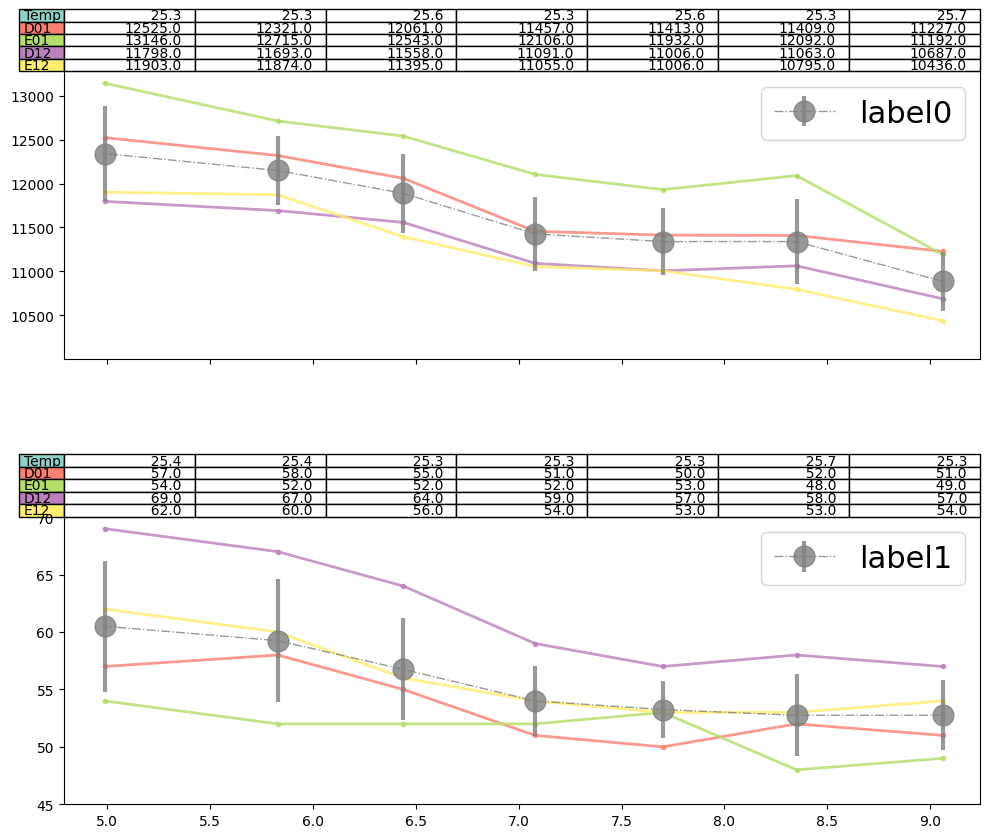

In [26]:
g = ph_an.plot_buffer()

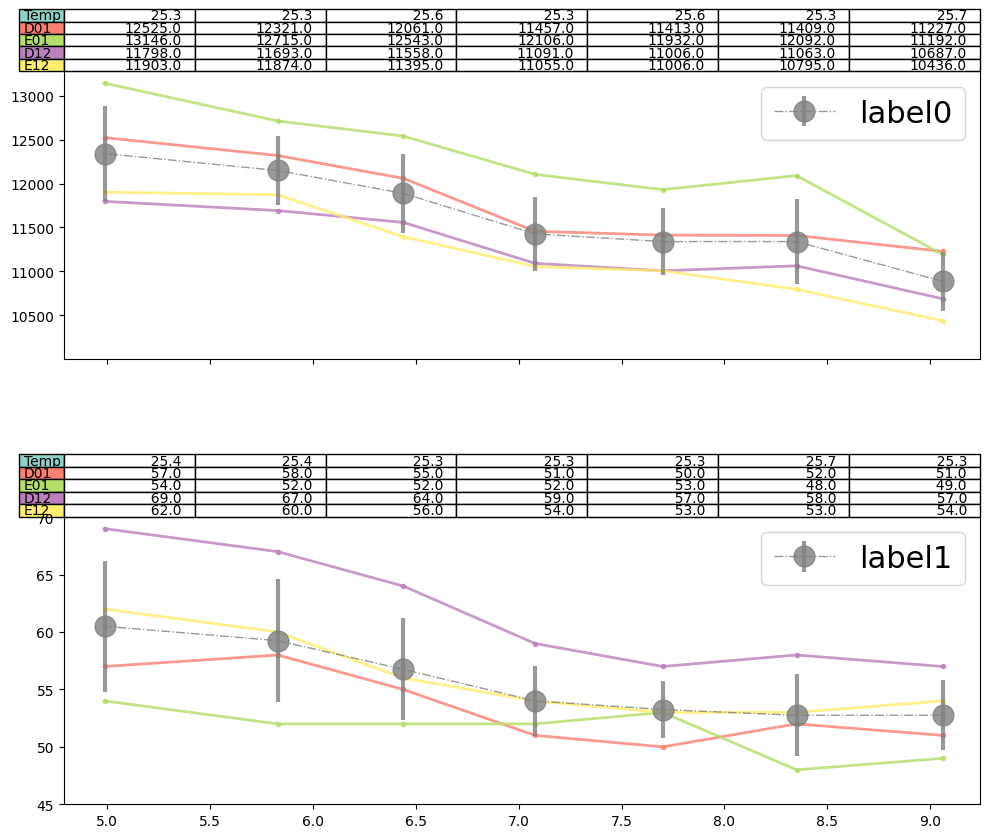

In [27]:
ph_an.dilution_correction('additions.pH')
g = ph_an.plot_buffer()

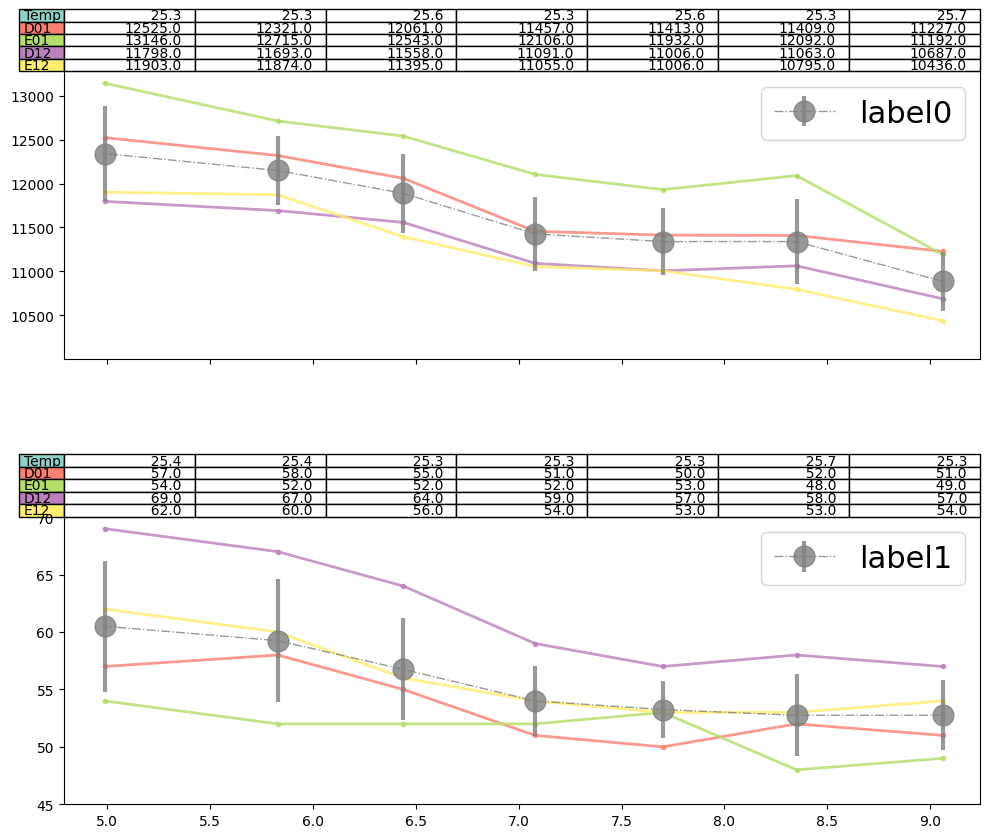

In [28]:
ph_an.metadata_normalization()
g = ph_an.plot_buffer()

## Cl titration analysis

In [29]:
cl = prtecan.Titration('list.cl')
cl_an = prtecan.TitrationAnalysis(cl, 'scheme.txt')
print(cl_an.scheme)
cl_an.subtract_bg()
cl_an.dilution_correction('additions.cl')

/home/dan/workspace/ClopHfit/src/clophfit/prtecan.py:390: UserWarning: OVER value in H02 well for ['Label1'] of tecanfile: pH5.0_200214.xls
  warnings.warn(


sample
G03            [A01, B12, H12]
NTT            [F01, C12, F12]
S202N          [C01, H01, G12]
V224Q          [B01, G01, A12]
buffer    [D01, E01, D12, E12]
Name: well, dtype: object


In [30]:
print(cl_an.conc)
cl_an.conc = cl_an.calculate_conc(cl_an.additions, 1000)
cl_an.conc

[0, 0, 0, 0, 0, 0, 0, 0, 0]


array([  0.        ,  17.54385965,  34.48275862,  50.84745763,
        66.66666667,  81.96721311,  96.77419355, 138.46153846,
       164.17910448])

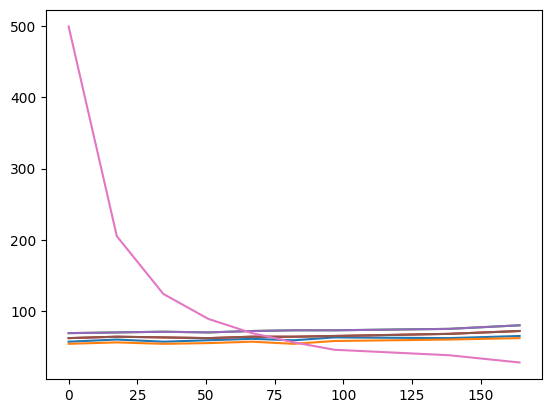

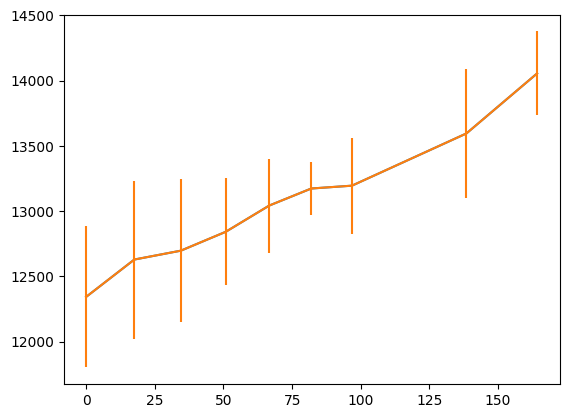

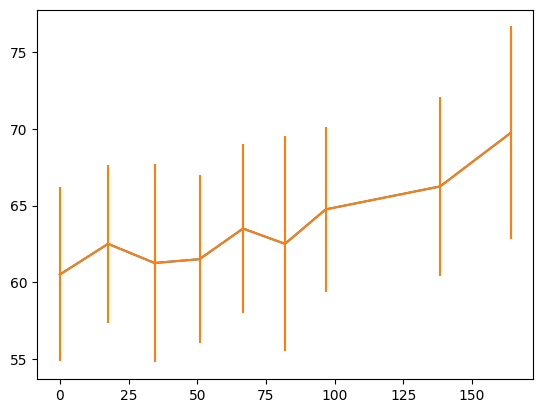

In [31]:
lbg = cl_an.labelblocksgroups[1]
x = cl_an.conc
plt.plot(x, lbg.buffer['D01'])
plt.plot(x, lbg.buffer['E01'])
plt.plot(x, lbg.buffer['D12'])
plt.plot(x, lbg.buffer['E12'])
plt.plot(x, cl.labelblocksgroups[1].data['D12'])
plt.plot(x, cl.labelblocksgroups[1].data['E12'])
plt.plot(x, lbg.data['A11'])
# plt.plot(x, np.array(cl.labelblocksgroups[1].data['A11']) / 2, '--')

for lbg in cl_an.labelblocksgroups:
    plt.figure()
    plt.plot(x, lbg.buffer['bg'])
    plt.errorbar(x, y=lbg.buffer['bg'], yerr=lbg.buffer['bg_sd'])

cl_an.metadata_normalization()

## Fitting

TitrationAnalysis class need API changes to better rationalize its use.

In [33]:
ph_an.fit('pH', fin=-1, tval=0.95)
type(ph_an.fittings)

list

In [34]:
# ph_an.fittings[1].to_csv('fit1-1.csv')
ph_an.fittings[1]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
A01,1,Both actual and predicted relative reductions ...,3,3.182446,21.987054,7.908998,24.461718,445.065923,0.081395,10.574585,17.948019,G03
A02,1,Both actual and predicted relative reductions ...,3,3.182446,22.071381,7.102121,45.135426,345.523065,0.110862,15.890041,11.483750,NaN
A03,1,Both actual and predicted relative reductions ...,3,3.182446,38.579405,7.029697,143.287451,897.125434,0.059367,22.194795,14.772656,NaN
A04,1,Both actual and predicted relative reductions ...,3,3.182446,201.347983,6.865680,47.810691,286.138292,0.452291,58.586552,31.891075,NaN
A05,1,Both actual and predicted relative reductions ...,3,3.182446,216.280773,6.925106,96.877552,640.108359,0.201253,57.426654,33.712397,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
H08,1,Both actual and predicted relative reductions ...,3,3.182446,356.611406,8.036820,142.304127,2346.789520,0.065109,40.799793,80.601762,NaN
H09,1,Both actual and predicted relative reductions ...,3,3.182446,85.596503,8.023813,49.986442,913.934905,0.081030,20.073457,39.028958,NaN
H10,1,Both actual and predicted relative reductions ...,3,3.182446,8.374404,8.060115,15.369087,280.064516,0.083785,6.205668,12.618094,NaN
H11,1,Both actual and predicted relative reductions ...,3,3.182446,5.332675,8.010700,23.806148,444.266076,0.041374,5.031855,9.628730,NaN


In [35]:
ph_an.fittings[1].loc[["H06", "A01"]]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
H06,1,Both actual and predicted relative reductions ...,3,3.182446,3.302961,8.015168,51.149474,866.672909,0.016813,3.954315,7.607932,NaN
A01,1,Both actual and predicted relative reductions ...,3,3.182446,21.987054,7.908998,24.461718,445.065923,0.081395,10.574585,17.948019,G03


In [36]:
key = 'H06'
lbg = ph_an.labelblocksgroups[1]
x = ph_an.conc
y = lbg.data[key]
dd = prtecan.fit_titration('pH', x[:-1], y[:-1])
dd

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB
0,1,Both actual and predicted relative reductions ...,3,3.182446,3.302961,8.015168,51.149474,866.672909,0.016813,3.954315,7.607932


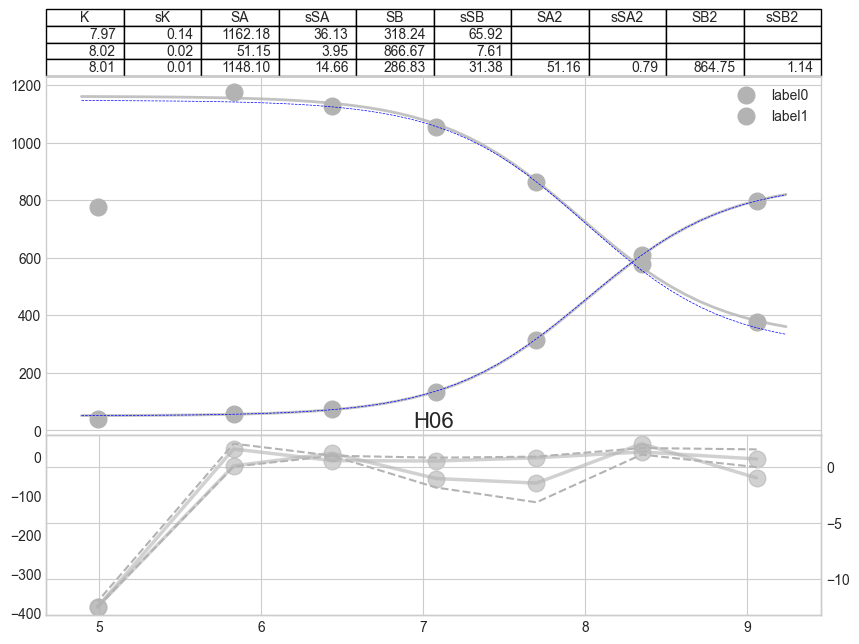

In [37]:
ph_an.plot_well('H06')

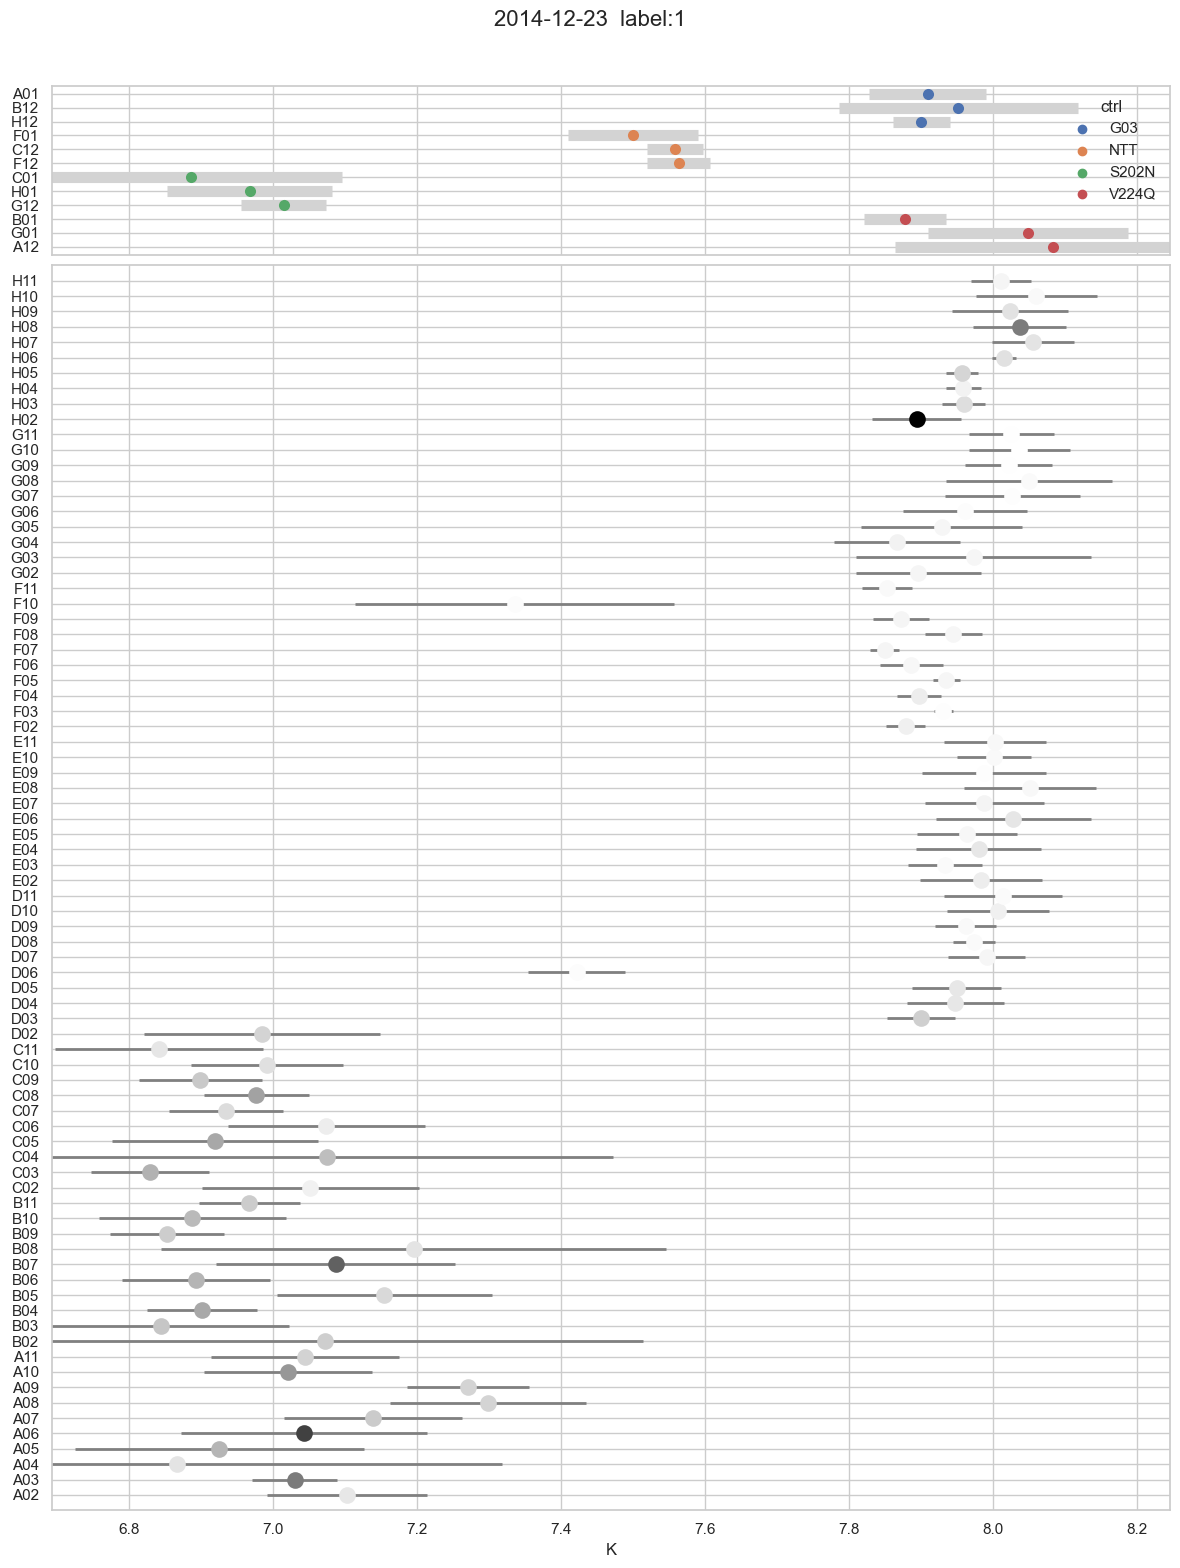

In [39]:
f = ph_an.plot_k(1, title='2014-12-23')

In [40]:
cl_an.fit('Cl', fin=None)

In [41]:
cl_an.plot_all_wells('cl.pdf')

In [42]:
ph_an.print_fitting(2)

          K      sK      SA     sSA      SB     sSB     SA2    sSA2     SB2    sSB2
  G03
A01    7.99    0.07     681      56     171       2      42      21     447      10 
B12    8.07    0.12     405       5     174       8      36      37     246       7 
H12    7.92    0.03     623      44     134      72      32       8     507       2 
  NTT
F01    7.50    0.02    2131       5     732       6     104      15     704       1 
C12    7.70    0.11     654      87     198       7      46      11     223       2 
F12    7.57    0.06     692      23     285      28      41      19     245       0 
  S202N
C01    7.26    0.26    1879      15    1101      92     139      82     649      43 
H01    7.14    0.08    1454       5     769      62      79       5     465       4 
G12    7.04    0.14     738      77     301      19      43      45     206       0 
  V224Q
B01    7.89    0.01    1660      19     750      30      44       0    1354       1 
G01    8.10    0.03    1791      36   

### selection

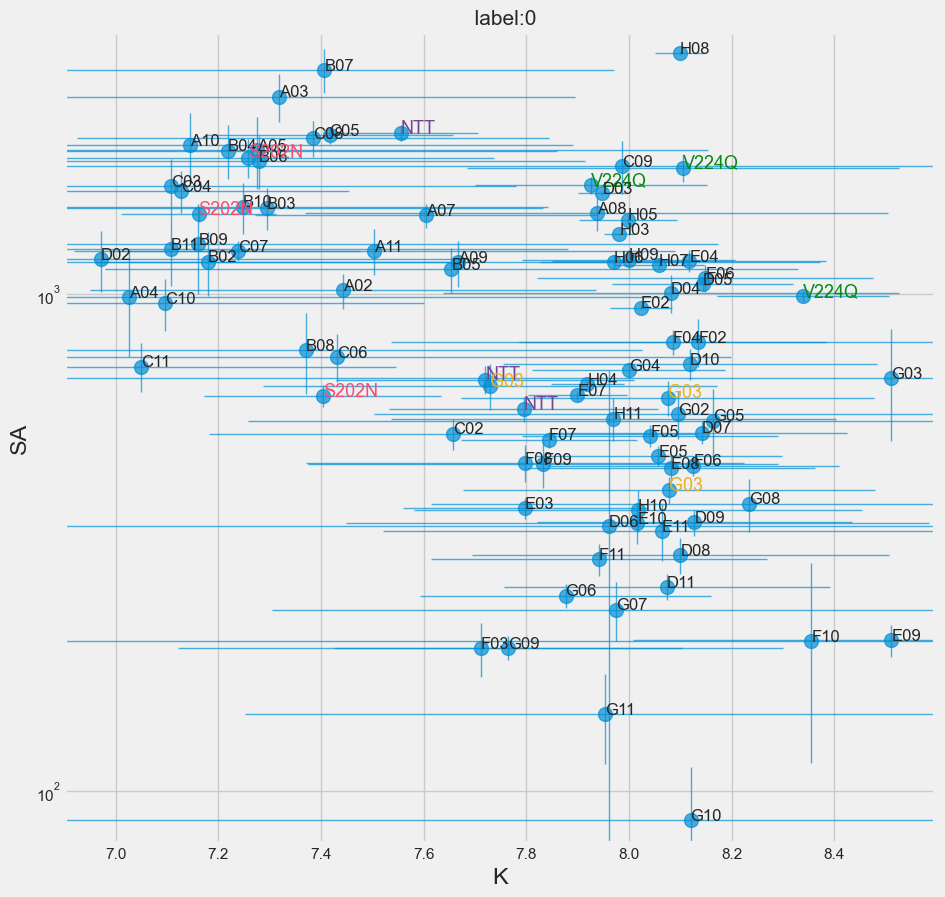

In [43]:
f = ph_an.plot_ebar(0)

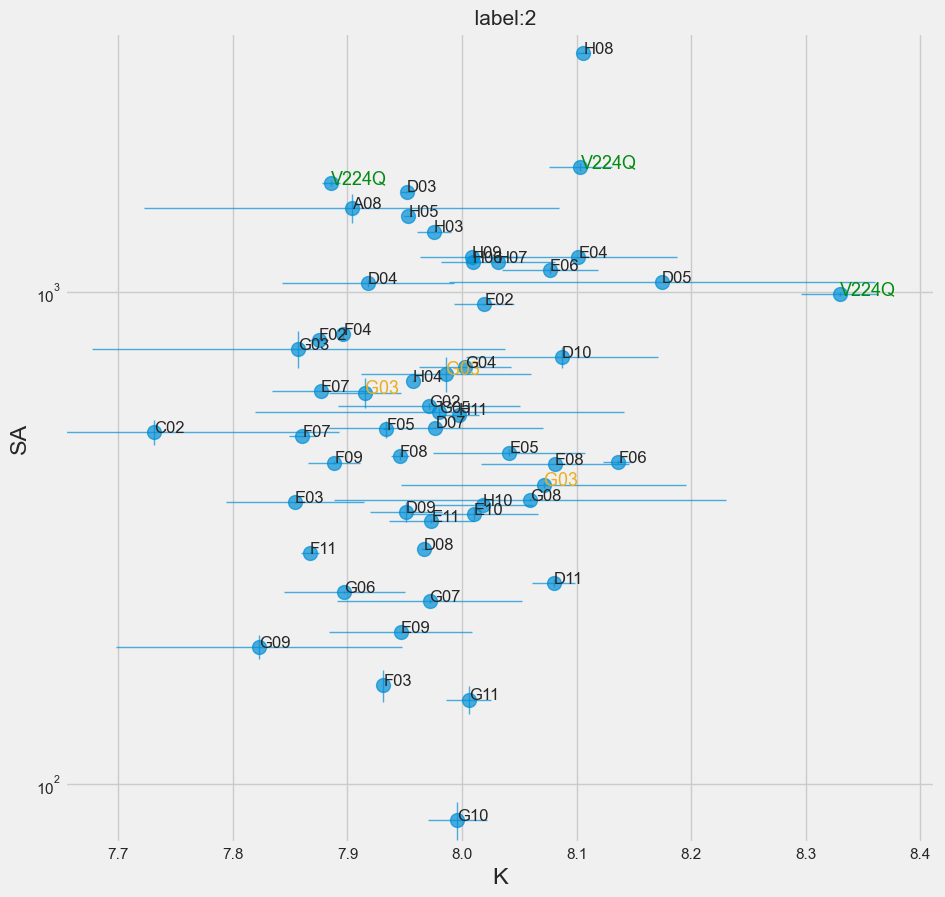

In [44]:
f = ph_an.plot_ebar(2, xmin=7.7, ymin=25)

/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/

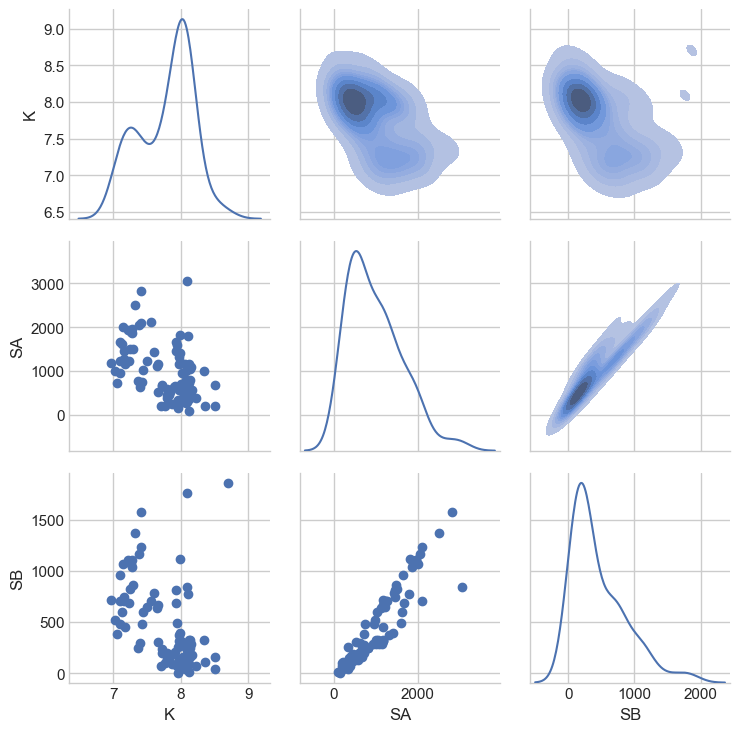

In [45]:
import seaborn as sb

sb.set_style('whitegrid')
g = sb.PairGrid(
    ph_an.fittings[0],
    x_vars=['K', 'SA', 'SB'],
    y_vars=['K', 'SA', 'SB'],
    # hue='SB',
    palette='Blues',
    diag_sharey=False,
)

g.map_lower(plt.scatter)
g.map_upper(sb.kdeplot, fill=True)
g.map_diag(sb.kdeplot)

Fit first (0) and second (1) dataset and global (2).

/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home

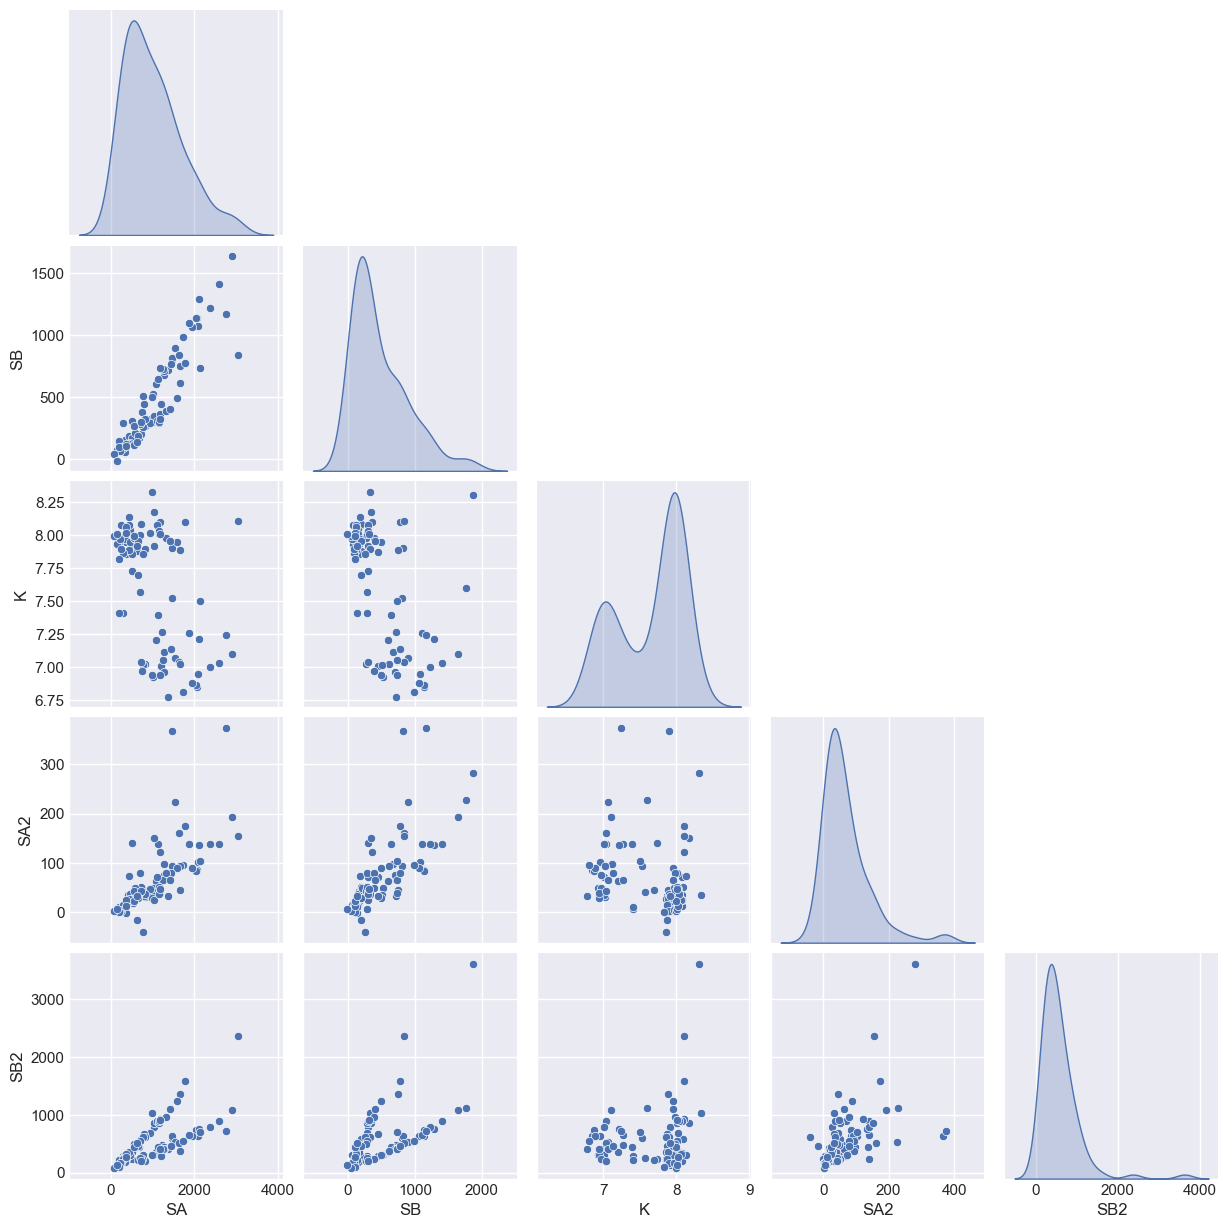

In [46]:
with sb.axes_style("darkgrid"):
    g = sb.pairplot(
        ph_an.fittings[2][["SA", "SB", "K", "SA2", "SB2"]],
        # hue='SB',
        palette='Reds',
        corner=True,
        diag_kind="kde",
    )

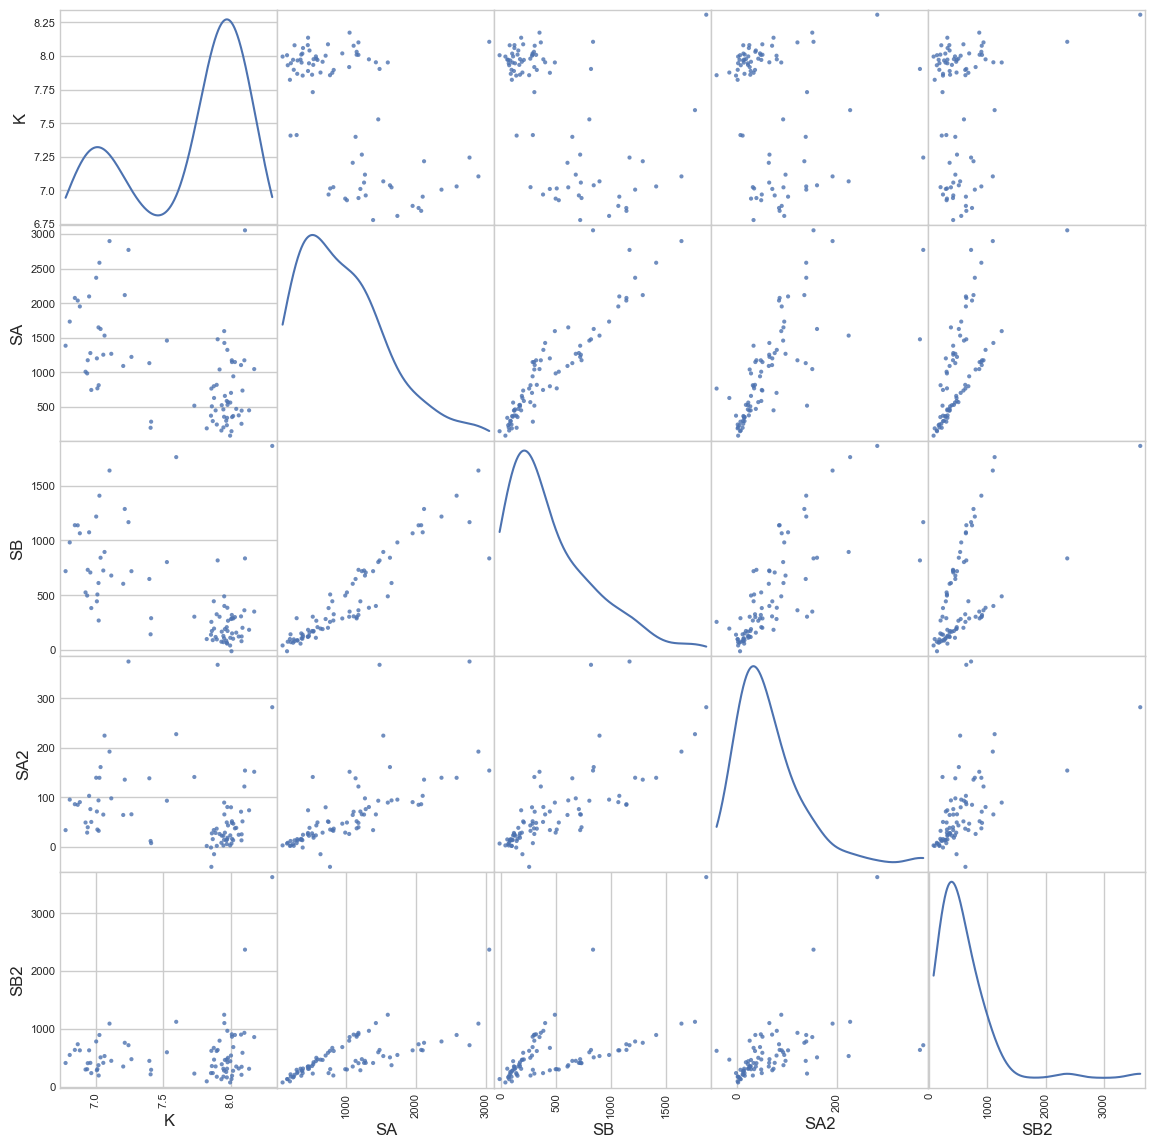

In [47]:
from pandas.plotting import scatter_matrix


def plot_matrix(tit, lb):
    df = tit.fittings[lb].loc[tit.keys_unk]
    try:
        f = scatter_matrix(
            df[['K', 'SA', 'SB', 'SA2', 'SB2']],
            figsize=(14, 14),
            diagonal='kde',
            alpha=0.8,
        )
    except KeyError:
        f = scatter_matrix(
            df[['K', 'SA', 'SB']], figsize=(10, 10), diagonal='kde', alpha=0.8
        )
    return f


f = plot_matrix(ph_an, 2)

### combining

In [48]:
res_unk = ph_an.fittings[1].loc[ph_an.keys_unk].sort_index()
res_unk["well"] = res_unk.index

<Figure size 2400x1400 with 0 Axes>

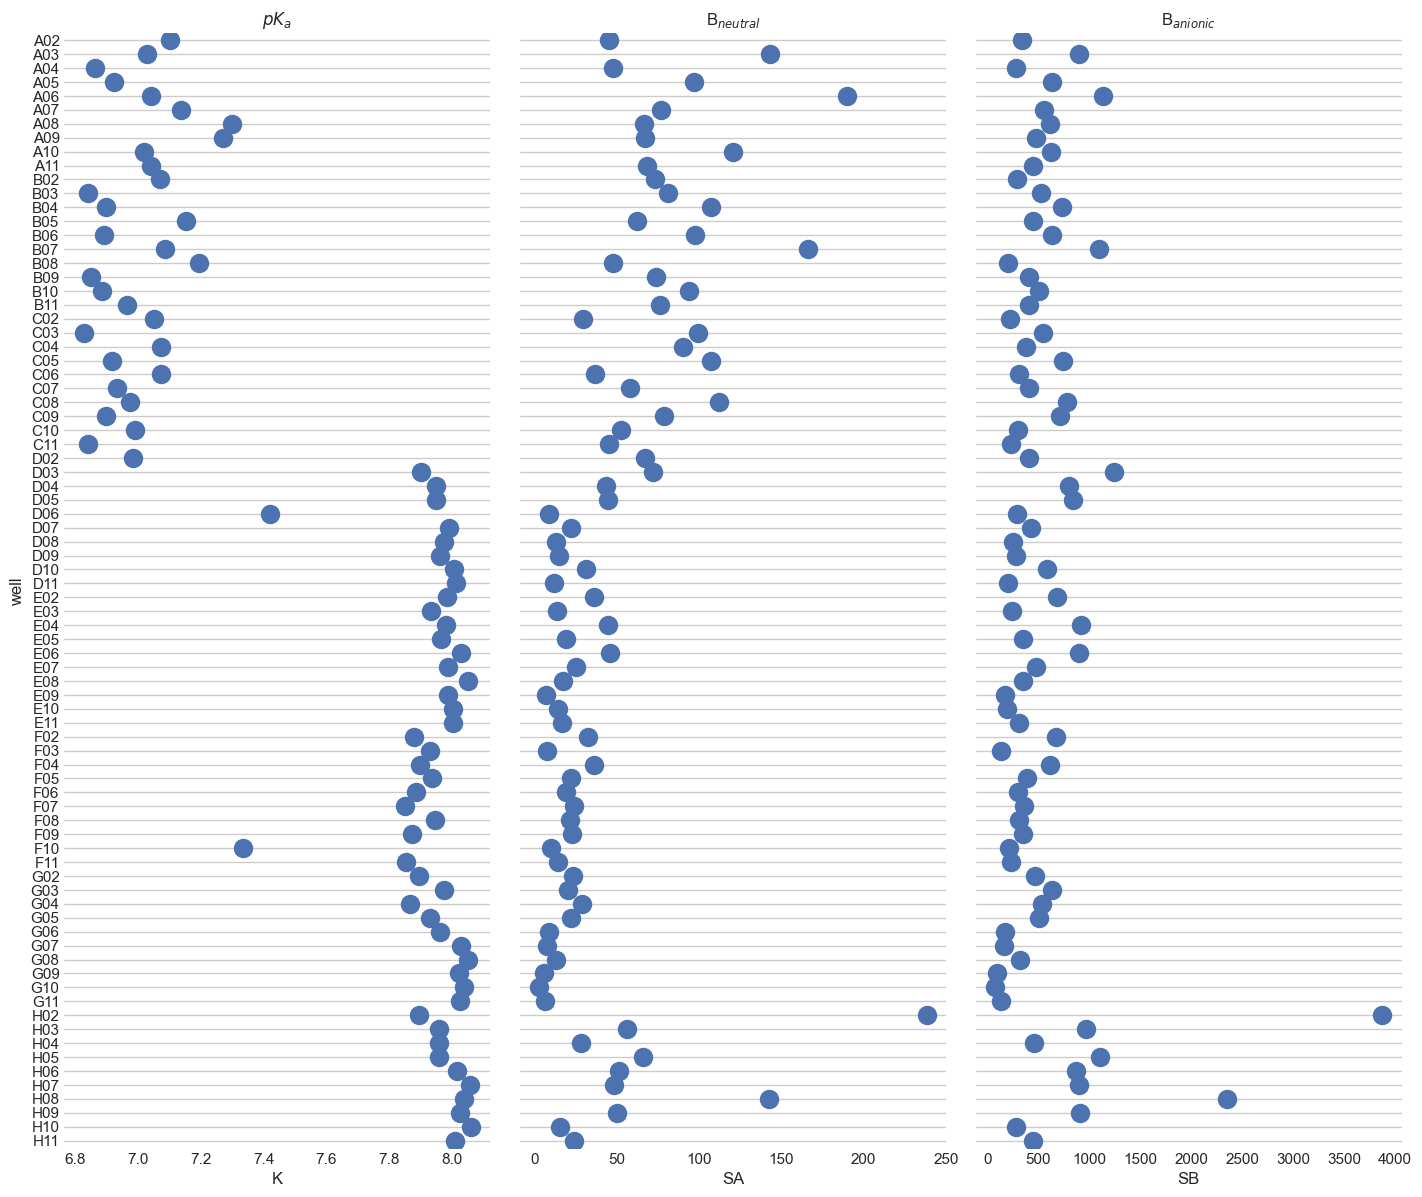

In [49]:
# g = sns.FacetGrid(data=res2, row='well',  margin_titles=True)
# g.map(plt.errorbar, 'K', range(1), xerr='sK', palette='Oranges_d') # x, y,
f = plt.figure(figsize=(24, 14))

# Make the PairGrid
g = sb.PairGrid(
    res_unk,
    x_vars=["K", "SA", "SB"],
    y_vars="well",
    height=12,
    aspect=0.4,
)


# Draw a dot plot using the stripplot function
g.map(sb.stripplot, size=14, orient="h", palette="Set2", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["$pK_a$", "B$_{neutral}$", "B$_{anionic}$"]


for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sb.despine(left=True, bottom=True)